# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [31]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sqlalchemy import create_engine
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import pickle

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')
df = pd.read_sql_table('InsertTableName', engine)
X = df.loc[:, 'message']
Y = df.iloc[:, 4:]

,id,message,original,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
genre,,,,,,,,,,,,,,,,,,,,,
direct,10696,10696,10094,10696,10696,10696,10696,10696,10696,10696,...,10696,10696,10696,10696,10696,10696,10696,10696,10696,10696
news,12960,12960,0,12960,12960,12960,12960,12960,12960,12960,...,12960,12960,12960,12960,12960,12960,12960,12960,12960,12960
social,2359,2359,0,2359,2359,2359,2359,2359,2359,2359,...,2359,2359,2359,2359,2359,2359,2359,2359,2359,2359


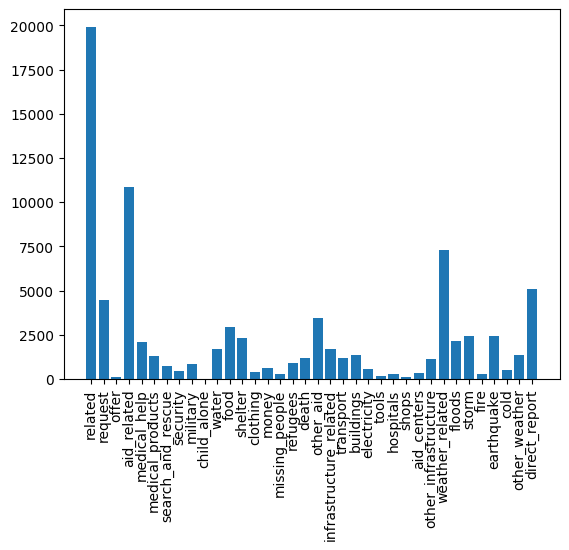

In [5]:
# look into the data a little bit
column_names = Y.columns
x = range(len(column_names))
y = Y.sum()

# histogramm of the labels
fig, ax = plt.subplots(1, 1)
_ = ax.bar(x, y)
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(column_names, rotation=90)
plt.show()

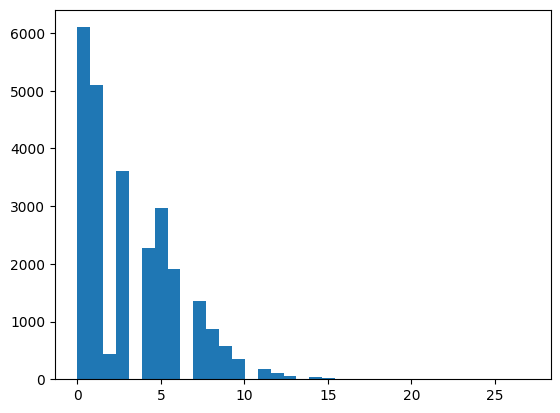

In [6]:
# histogram over number of labels for each data point
# look into the data a little bit
column_names = Y.columns
x = range(len(column_names))
y = Y.T.sum()

# histogramm of the labels
fig, ax = plt.subplots(1, 1)
_ = ax.hist(y, bins=35)
plt.show()

In [7]:
Y['related'].max()

1

### 2. Write a tokenization function to process your text data

In [8]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [49]:
pipeline = Pipeline([
    ('features', FeatureUnion([

        ('nlp_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize, 
                token_pattern=None)), # to deactivate warning
            ('tfidf', TfidfTransformer())
        ])),

        # ('txt_len', TextLengthExtractor())
    ])),

    ('clf', MultiOutputClassifier(
        Pipeline([
            ('smt', SMOTE()),
            ('LogReg', LogisticRegressionCV(solver='liblinear'))
        ])
    ))
])



### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.iloc[:,:3], random_state=42)
idx_empty_column = Y_train.any(axis=0)
Y_train = Y_train.loc[:, idx_empty_column]
Y_test = Y_test.loc[:, idx_empty_column]

Before training the pipeline, I want to see, whether SMOTE works.

In [36]:
Y_train_loc = Y_train.iloc[:, 0]
Y_test_loc = Y_test.iloc[:, 0]
# count vectorization
X_vectorized = CountVectorizer(tokenizer=tokenize, 
                token_pattern=None).fit_transform(
                    X_train
                )
# TF-IDF transformation
X_tfidf = TfidfTransformer().fit_transform(X_vectorized)

# create a model for one output
X_SMOTE, Y_SMOTE = SMOTE(sampling_strategy='all').fit_resample(X_tfidf, Y_train_loc)

In [47]:
# fit the model
mdl = LogisticRegressionCV(
    solver='liblinear'
).fit(X_SMOTE, Y_SMOTE,)

<AxesSubplot: >

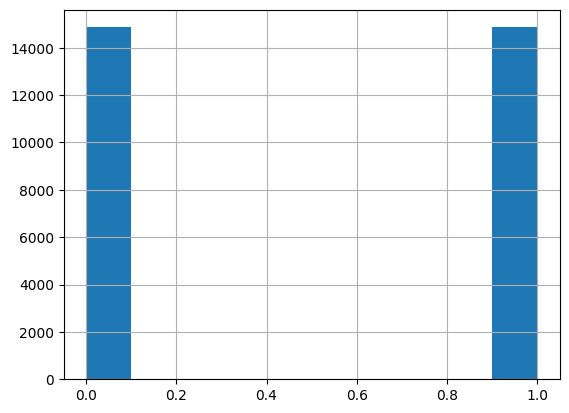

In [26]:
Y_SMOTE.hist()

In [48]:
Y_train_pred_loc = mdl.predict(X_SMOTE)
print(classification_report(Y_SMOTE, Y_train_pred_loc))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     14866
           1       0.98      0.93      0.96     14866

    accuracy                           0.96     29732
   macro avg       0.96      0.96      0.96     29732
weighted avg       0.96      0.96      0.96     29732



Fit the model.

In [50]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('nlp_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(token_pattern=None,
                                                                                  tokenizer=<function tokenize at 0x000001E0C4FB9990>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())]))])),
                ('clf',
                 MultiOutputClassifier(estimator=Pipeline(steps=[('smt',
                                                                  SMOTE()),
                                                                 ('LogReg',
                                                                  LogisticRegressionCV(solver='liblinear'))])))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [60]:
def classification_report_all_labels(Y_test, Y_test_pred):
    """
    Prints the classification report for all labels in Y_test and Y_test_pred.
    """
    for idx, column in enumerate(Y_test.columns):
        print('Column: {}'.format(column))
        print(classification_report(Y_test.iloc[:, idx], Y_test_pred[:, idx]))

In [61]:
Y_test_pred = pipeline.predict(X_test)

classification_report_all_labels(Y_test, Y_test_pred)



Column: related
              precision    recall  f1-score   support

           0       0.27      0.40      0.32      1456
           1       0.80      0.68      0.74      5048

    accuracy                           0.62      6504
   macro avg       0.53      0.54      0.53      6504
weighted avg       0.68      0.62      0.64      6504

Column: request
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      5317
           1       0.34      0.47      0.39      1187

    accuracy                           0.73      6504
   macro avg       0.60      0.63      0.61      6504
weighted avg       0.77      0.73      0.75      6504

Column: offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6474
           1       0.00      0.00      0.00        30

    accuracy                           0.99      6504
   macro avg       0.50      0.50      0.50      6504
weighted avg       0.99     

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
# a = ['help, help, help',
#     'please help me']

# b = CountVectorizer(tokenizer=tokenize).fit_transform(a)

# transformer = TfidfTransformer(smooth_idf=False)

# # use counts from count vectorizer results to compute tf-idf values
# tfidf = transformer.fit_transform(b)

# # convert sparse matrix to numpy array to view
# tfidf.toarray()
# # b.toarray()

In [52]:
pipeline.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'features', 'clf', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__verbose', 'features__nlp_pipeline', 'features__nlp_pipeline__memory', 'features__nlp_pipeline__steps', 'features__nlp_pipeline__verbose', 'features__nlp_pipeline__vect', 'features__nlp_pipeline__tfidf', 'features__nlp_pipeline__vect__analyzer', 'features__nlp_pipeline__vect__binary', 'features__nlp_pipeline__vect__decode_error', 'features__nlp_pipeline__vect__dtype', 'features__nlp_pipeline__vect__encoding', 'features__nlp_pipeline__vect__input', 'features__nlp_pipeline__vect__lowercase', 'features__nlp_pipeline__vect__max_df', 'features__nlp_pipeline__vect__max_features', 'features__nlp_pipeline__vect__min_df', 'features__nlp_pipeline__vect__ngram_range', 'features__nlp_pipeline__vect__preprocessor', 'features__nlp_pipeline__vect__stop_words', 'features__nlp_pipeline__vect__strip_accents', 'features__nlp_pipeline__vect__token_pattern

In [56]:
# define parameters for grid search
parameters= {
    # # tokenizer
    # 'features__nlp_pipeline__vect__tokenizer':
    #     [None, tokenize],
    # # stop_words
    # 'features__nlp_pipeline__vect__stop_words':
    #     ['english', stopwords.words('english')],
    # max features
    # 'features__nlp_pipeline__vect__min_df':
    #     [1, 2, 10],
    # classifier
    'clf__estimator__LogReg':
        [
            LogisticRegression(solver='liblinear'),
            MultinomialNB()
        ]
}

# parameters = clf__estimator LogisticRegression, LogisticRegressionCV
# tokenizer None tokenize
# stop_words stopwords
# max_features 0 11111 999999
# smooth_idf True False
# norm{‘l1’, ‘l2’} 
# penalty l1 l2 elasticnet
# l1_ratio

In [57]:

cv = GridSearchCV(pipeline, param_grid=parameters)

In [58]:
cv.fit(X_train, Y_train)

GridSearchCV(estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('nlp_pipeline',
                                                                        Pipeline(steps=[('vect',
                                                                                         CountVectorizer(token_pattern=None,
                                                                                                         tokenizer=<function tokenize at 0x000001E0C4FB9990>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())]))])),
                                       ('clf',
                                        MultiOutputClassifier(estimator=Pipeline(steps=[('smt',
                                                                                         SMOTE()),
                                                                                        ('LogReg',
                                                                                         LogisticRegressionCV(solver='liblinear'))])))]),
             param_grid={'clf__estimator__LogReg': [LogisticRegression(solver='liblinear'),
                                                    MultinomialNB()]})

In [59]:
cv.cv_results_

{'mean_fit_time': array([4.70096049, 4.08036466]),
 'std_fit_time': array([0.58025815, 0.03118802]),
 'mean_score_time': array([0.86958251, 0.81406846]),
 'std_score_time': array([0.09625733, 0.02106304]),
 'param_clf__estimator__LogReg': masked_array(data=[LogisticRegression(solver='liblinear'),
                    MultinomialNB()],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__estimator__LogReg': LogisticRegression(solver='liblinear')},
  {'clf__estimator__LogReg': MultinomialNB()}],
 'split0_test_score': array([0.49628491, 0.45580323]),
 'split1_test_score': array([0.49436187, 0.45848283]),
 'split2_test_score': array([0.48872373, 0.44951307]),
 'split3_test_score': array([0.49589954, 0.45002563]),
 'split4_test_score': array([0.48411071, 0.4528447 ]),
 'mean_test_score': array([0.49187615, 0.45333389]),
 'std_test_score': array([0.00473378, 0.00341736]),
 'rank_test_score': array([1, 2])}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [62]:
mdl_chosen = cv.best_estimator_

Y_test_pred_cv = pipeline.predict(X_test)

classification_report_all_labels(Y_test, Y_test_pred_cv)



Column: related
              precision    recall  f1-score   support

           0       0.27      0.40      0.32      1456
           1       0.80      0.68      0.74      5048

    accuracy                           0.62      6504
   macro avg       0.53      0.54      0.53      6504
weighted avg       0.68      0.62      0.64      6504

Column: request
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      5317
           1       0.34      0.47      0.39      1187

    accuracy                           0.73      6504
   macro avg       0.60      0.63      0.61      6504
weighted avg       0.77      0.73      0.75      6504

Column: offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6474
           1       0.00      0.00      0.00        30

    accuracy                           0.99      6504
   macro avg       0.50      0.50      0.50      6504
weighted avg       0.99     

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [68]:
filename = 'test_model.pkl'
pickle.dump(cv.best_estimator_, open(filename, 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.